# Digital Image Processing Exercise 4_2

Dr. Rahmati

By: Gholamreza Dar

Summer 2022

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

import cv2

from numba import jit, njit


## Functions

In [3]:

def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def disp(img, title='', s=8, vmin=None, vmax=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray', interpolation='None')
    plt.title(title)
    plt.show()
    
def before_after(img_a, img_b, name="", vmin=None, vmax=None, effect_name="Processed"):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f"{name} Original")
    axs[1].set_title(f"{name} {effect_name}")
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()


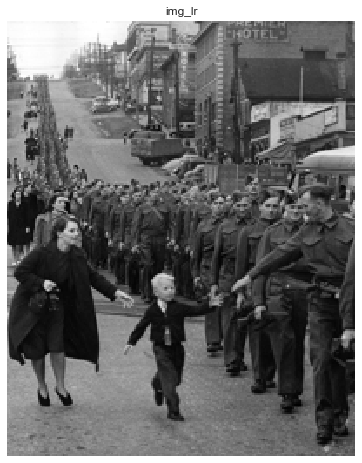

In [4]:
## Loading Images
img_gt = cv2.imread('inputs/P2/wait_for_me_daddy_gt.png', 0).astype(np.float32)
img_lr = cv2.imread('inputs/P2/wait_for_me_daddy_lr.png', 0).astype(np.float32)

img_top_left = cv2.imread('inputs/P2/wait_for_me_daddy_[-0.3,+0.4].png', 0).astype(np.float32)
img_top_right = cv2.imread('inputs/P2/wait_for_me_daddy_[+0.6,+0.2].png', 0).astype(np.float32)
img_bottom_right = cv2.imread('inputs/P2/wait_for_me_daddy_[+0.1,-0.5].png', 0).astype(np.float32)
img_bottom_left = cv2.imread('inputs/P2/wait_for_me_daddy_[-0.2,-0.3].png', 0).astype(np.float32)

disp(img_lr, 'img_lr')

## Nearest Neighbor

In [5]:
def nn_interpolation(img, s=2):
    h, w = img.shape[0], img.shape[1]
    new_h, new_w = h*s, w*s
    result = np.zeros((new_h, new_w))

    for i in range(new_h):
        for j in range(new_w):
            interpolated_value = img[i//s, j//s]
            result[i,j] = interpolated_value
    return result

@njit
def nn_interpolation_jit(img, s=2):
    h, w = img.shape[0], img.shape[1]
    new_h, new_w = h*s, w*s
    result = np.zeros((new_h, new_w))

    for i in range(new_h):
        for j in range(new_w):
            interpolated_value = img[i//s, j//s]
            result[i,j] = interpolated_value
    return result

In [6]:
# %%timeit
# resized_img_nn = nn_interpolation(img_lr)

101 ms ± 6.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
resized_img_nn = nn_interpolation_jit(img_lr)

682 µs ± 66.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


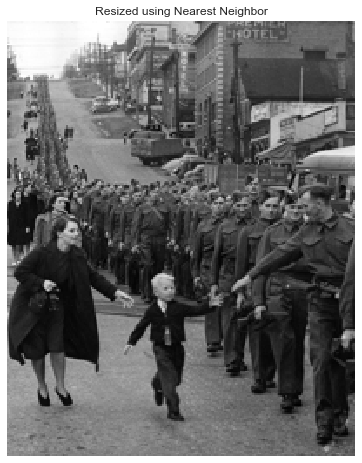

Old Size: (250, 200)
New Size: (500, 400)


In [8]:
resized_img_nn = nn_interpolation_jit(img_lr)
disp(resized_img_nn, "Resized using Nearest Neighbor")
cv2.imwrite("resized_img_nn.png", resized_img_nn)
print(f"Old Size: {img_lr.shape}")
print(f"New Size: {resized_img_nn.shape}")

## Bilinear

In [9]:
def bilinear_interpolation(img, s=2):
    h, w = img.shape[0], img.shape[1]
    new_h, new_w = h*s, w*s
    result = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h-1):
        for j in range(new_w-1):
            A = img[int(np.floor(i/s)), int(np.floor(j/s))]
            B = img[int(np.floor(i/s)), int(np.ceil(j/s))]
            C = img[int(np.ceil(i/s)), int(np.floor(j/s))]
            D = img[int(np.ceil(i/s)), int(np.ceil(j/s))]
            
            delta_x = j/s - np.floor(j/s)
            delta_y = i/s - np.floor(i/s)

            interpolated_value = \
                A*(1-delta_x)*(1-delta_y) +\
                B*(delta_x)*(1-delta_y)   +\
                C*(1-delta_x)*(delta_y)   +\
                D*(delta_x)*(delta_y)

            result[i,j] = interpolated_value
            
    return result

@njit
def bilinear_interpolation_jit(img, s=2):
    h, w = img.shape[0], img.shape[1]
    new_h, new_w = h*s, w*s
    result = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h-1):
        for j in range(new_w-1):
            A = img[int(np.floor(i/s)), int(np.floor(j/s))]
            B = img[int(np.floor(i/s)), int(np.ceil(j/s))]
            C = img[int(np.ceil(i/s)), int(np.floor(j/s))]
            D = img[int(np.ceil(i/s)), int(np.ceil(j/s))]
            
            delta_x = j/s - np.floor(j/s)
            delta_y = i/s - np.floor(i/s)

            interpolated_value = \
                A*(1-delta_x)*(1-delta_y) +\
                B*(delta_x)*(1-delta_y)   +\
                C*(1-delta_x)*(delta_y)   +\
                D*(delta_x)*(delta_y)

            result[i,j] = interpolated_value
            
    return result

In [10]:
%%timeit
resized_img_bilinear = bilinear_interpolation(img_lr)

5.22 s ± 321 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
resized_img_bilinear = bilinear_interpolation_jit(img_lr)

1.73 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


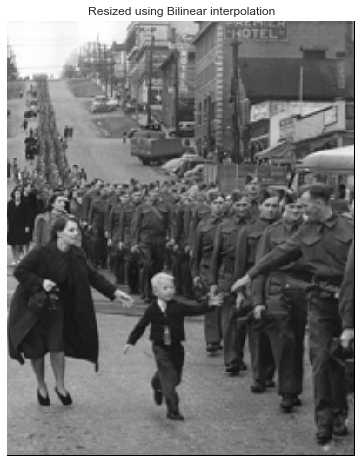

Old Size: (250, 200)
New Size: (500, 400)


In [20]:
resized_img_bilinear = bilinear_interpolation_jit(img_lr)
disp(resized_img_bilinear, "Resized using Bilinear interpolation")
cv2.imwrite("resized_img_bilinear.png", resized_img_bilinear)
print(f"Old Size: {img_lr.shape}")
print(f"New Size: {resized_img_bilinear.shape}")

## Nearest Value

In [15]:
def nearest_value_interpolation(img, s=2):
    h, w = img.shape[0], img.shape[1]
    new_h, new_w = h*s, w*s
    result = np.zeros((new_h, new_w), dtype=np.float32)

    bilinear_result = bilinear_interpolation_jit(img, s)

    for i in range(new_h-1):
        for j in range(new_w-1):
            A = img[int(np.floor(i/s)), int(np.floor(j/s))]
            B = img[int(np.floor(i/s)), int(np.ceil(j/s))]
            C = img[int(np.ceil(i/s)), int(np.floor(j/s))]
            D = img[int(np.ceil(i/s)), int(np.ceil(j/s))]
            
            # find the closest value to the bilinear result at  i,j
            closest_v = A
            for v in [B, C, D]:
                if np.abs(v - bilinear_result[i,j]) < np.abs(closest_v - bilinear_result[i,j]) :
                    closest_v = v

            result[i,j] = closest_v
            
    return result

@njit
def nearest_value_interpolation_jit(img, s=2):
    h, w = img.shape[0], img.shape[1]
    new_h, new_w = h*s, w*s
    result = np.zeros((new_h, new_w), dtype=np.float32)

    bilinear_result = bilinear_interpolation_jit(img, s)

    for i in range(new_h-1):
        for j in range(new_w-1):
            A = img[int(np.floor(i/s)), int(np.floor(j/s))]
            B = img[int(np.floor(i/s)), int(np.ceil(j/s))]
            C = img[int(np.ceil(i/s)), int(np.floor(j/s))]
            D = img[int(np.ceil(i/s)), int(np.ceil(j/s))]
            
            # find the closest value to the bilinear result at  i,j
            closest_v = A
            for v in [B, C, D]:
                if np.abs(v - bilinear_result[i,j]) < np.abs(closest_v - bilinear_result[i,j]) :
                    closest_v = v

            result[i,j] = closest_v
            
    return result

In [16]:
# %%timeit
# resized_img_nv = nearest_value_interpolation(img_lr)

4.12 s ± 190 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
resized_img_nv = nearest_value_interpolation_jit(img_lr)

4.52 ms ± 780 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


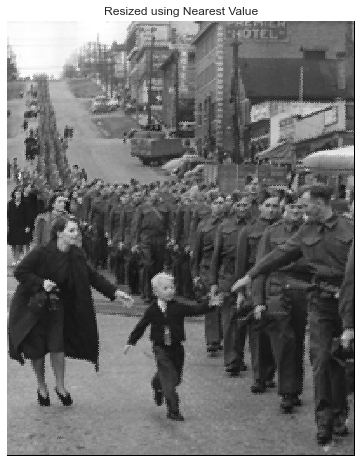

Old Size: (250, 200)
New Size: (500, 400)


In [21]:
resized_img_nv = nearest_value_interpolation_jit(img_lr)
disp(resized_img_nv, "Resized using Nearest Value")
cv2.imwrite("resized_img_nv.png", resized_img_nv)
print(f"Old Size: {img_lr.shape}")
print(f"New Size: {resized_img_nv.shape}")

## non-uniform

In [38]:
def non_uniform_interpolation(A, B, C, D):

    img_a_dist = np.linalg.norm(np.array([-0.3, 0.4]))
    img_b_dist = np.linalg.norm(np.array([0.6, 0.2]))
    img_c_dist = np.linalg.norm(np.array([-0.2, 0.3]))
    img_d_dist = np.linalg.norm(np.array([0.1, -0.5]))
    sum_dists = img_a_dist + img_b_dist + img_c_dist + img_d_dist
    normalizer = (sum_dists-img_a_dist) + (sum_dists-img_b_dist) + (sum_dists-img_c_dist) + (sum_dists-img_d_dist)

    h, w = A.shape[0], A.shape[1]
    new_h, new_w = h*2, w*2
    result = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h):
        for j in range(new_w):
            i_small = i//2
            j_small = j//2

            result[i,j] = (A[i_small,j_small] * (sum_dists-img_a_dist) + B[i_small,j_small] * (sum_dists-img_b_dist) + C[i_small, j_small] * (sum_dists-img_c_dist) + D[i_small, j_small] * (sum_dists-img_d_dist))/normalizer

    return result

@njit
def non_uniform_interpolation_jit(A, B, C, D):

    img_a_dist = np.linalg.norm(np.array([-0.3, 0.4]))
    img_b_dist = np.linalg.norm(np.array([0.6, 0.2]))
    img_c_dist = np.linalg.norm(np.array([-0.2, 0.3]))
    img_d_dist = np.linalg.norm(np.array([0.1, -0.5]))
    sum_dists = img_a_dist + img_b_dist + img_c_dist + img_d_dist
    normalizer = (sum_dists-img_a_dist) + (sum_dists-img_b_dist) + (sum_dists-img_c_dist) + (sum_dists-img_d_dist)

    h, w = A.shape[0], A.shape[1]
    new_h, new_w = h*2, w*2
    result = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h):
        for j in range(new_w):
            i_small = i//2
            j_small = j//2

            result[i,j] = (A[i_small,j_small] * (sum_dists-img_a_dist) + B[i_small,j_small] * (sum_dists-img_b_dist) + C[i_small, j_small] * (sum_dists-img_c_dist) + D[i_small, j_small] * (sum_dists-img_d_dist))/normalizer

    return result

In [39]:
%%timeit
images = [img_top_left, img_top_right, img_bottom_left, img_bottom_right]
resized_img_non_uniform = non_uniform_interpolation(*images)

2.87 s ± 219 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit
images = [img_top_left, img_top_right, img_bottom_left, img_bottom_right]
resized_img_non_uniform = non_uniform_interpolation_jit(*images)

1.43 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


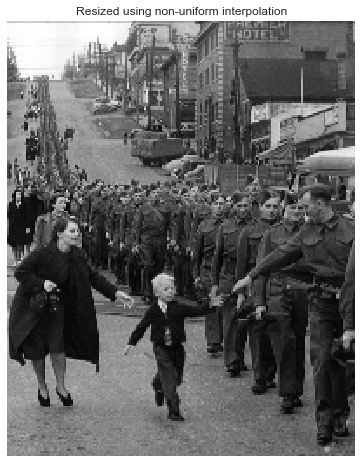

Old Size: (250, 200)
New Size: (500, 400)


In [41]:
images = [img_top_left, img_top_right, img_bottom_left, img_bottom_right]
resized_img_non_uniform = non_uniform_interpolation_jit(*images)
disp(resized_img_non_uniform, "Resized using non-uniform interpolation")
cv2.imwrite("resized_img_non_uniform.png", resized_img_non_uniform)
print(f"Old Size: {img_bottom_left.shape}")
print(f"New Size: {resized_img_non_uniform.shape}")

In [49]:
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

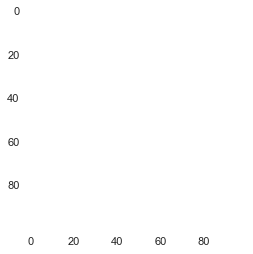

In [52]:
img = np.ones((100,100), dtype=np.uint8)*255
# img = img.astype(np.uint8)
# img
plt.imshow(img, cmap="gray", vmin=0, vmax=255)